# Neural Networks for Annomaly (Outlier) Detection 
* Source : https://github.com/abelusha/AutoEncoders-for-Anomaly-Detection

<html><img src='https://raw.githubusercontent.com/abelusha/AutoEncoders-for-Anomaly-Detection/master/outlier_pic.jpg', width = 500, height = 600></html>


Agenda:

- Data Exploration & Preprocessing
- Model Building
- Model Evaluation 
- Model Interpretation



In [21]:
import warnings
warnings.filterwarnings("ignore")
!pip install ann_visualizer

In [22]:
import numpy
import pandas
import matplotlib
import seaborn
import tensorflow
from  tensorflow import keras

In [23]:
print('Numpy version      :' , numpy.__version__)
print('Pandas version     :' ,pandas.__version__)
print('matplotlib version :' ,matplotlib.__version__)
print('seaborn version    :' , seaborn.__version__)
print('tensorflow version :' , tensorflow.__version__)
print('keras version      :' , keras.__version__)

Numpy version      : 1.18.5
Pandas version     : 1.1.4
matplotlib version : 3.2.2
seaborn version    : 0.11.0
tensorflow version : 2.3.0
keras version      : 2.4.0


In [24]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
import matplotlib.pyplot as plt
plt.rcdefaults()
from pylab import rcParams
import seaborn as sns
%matplotlib inline

####### Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex


# Load Data

In [25]:
![ ! -f JADS_CarrerDay_Data.csv ]&&wget https://raw.githubusercontent.com/Finfra/AI_Vision/master/data/JADS_CarrerDay_Data.csv
df = pd.read_csv('JADS_CarrerDay_Data.csv',index_col=0)

In [26]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549],
           dtype='int64', length=4550)

In [27]:
df.reset_index(inplace=True, drop= True)

In [28]:
df.index

RangeIndex(start=0, stop=4550, step=1)

In [29]:
df.head()

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,Label
0,7.52785,100.0,22.2,47.8,13.0,925,951,938,954,0
1,7.43006,100.0,22.2,47.8,12.9,931,953,935,950,0
2,7.40669,100.0,22.2,47.8,13.0,932,952,937,950,0
3,7.52365,100.0,22.2,47.9,13.0,923,950,942,950,0
4,7.43734,100.0,22.3,47.6,13.3,920,952,945,954,0


In [30]:
df.shape

(4550, 10)

In [31]:
df.Label.value_counts()

0    4444
1     106
Name: Label, dtype: int64

In [32]:
df.Label.value_counts(normalize=True)*100

0    97.67033
1     2.32967
Name: Label, dtype: float64

# Highly Imbalanced Data

In [33]:
df.columns

Index(['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9', 'Label'], dtype='object')

In [34]:
numerical_cols = ['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9']

In [35]:
df.Label.unique()

array([0, 1])

In [36]:
labels = df['Label'].astype(int)
labels[labels != 0] = 1

In [37]:
len(labels[labels !=0])

106

# Data Exploration

In [38]:
df.Label.value_counts().tolist()

[4444, 106]

Text(0.5, 1.0, 'Data per Label')

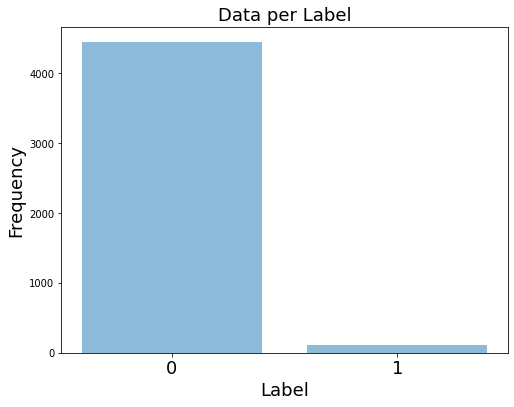

In [39]:
plt.figure(figsize=(8,6))
objects = tuple(['0', '1']) 
y_pos = np.arange(len(objects))
x   = np.arange(len(objects))
y   = df.Label.value_counts().tolist()
#plt.ylim([0, 1.2])
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(y_pos, objects,fontsize=18)
plt.xlabel('Label', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Data per Label',fontsize=18)


# Data Preprocessing

- Let's leverage the fact we know the labels of our data

In [40]:
RANDOM_SEED = 101

X_train, X_test = train_test_split(df, test_size=0.2, random_state = RANDOM_SEED)

X_train = X_train[X_train['Label'] == 0]
X_train = X_train.drop(['Label'], axis=1)
y_test  = X_test['Label']
X_test  = X_test.drop(['Label'], axis=1)
X_train = X_train.values
X_test  = X_test.values
print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)

Training data size   : (3558, 9)
Validation data size : (910, 9)


# Data Scaling

In [41]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Modeling

# AutoEncoders

- Feed Forward Neural Network model for unsupervised tasks (No Lables)
- Model the identity function f(x) ≈  x (It encodes itself)
- Simple to undersatnd!
- Compress data and learn some features 

Ref:
https://probablydance.com/2016/04/30/neural-networks-are-impressively-good-at-compression/




<img src='AutoEncoders.png',>


# Reconstruction error


min $$L(x, x')  ≈ ||x - x'||^{2}$$

In [42]:
input_dim = X_train.shape[1]
encoding_dim = 6

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(encoding_dim / 4), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 60        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 9)                

In [43]:
nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        ).history

# validation_data=(X_test_scaled, X_test_scaled)

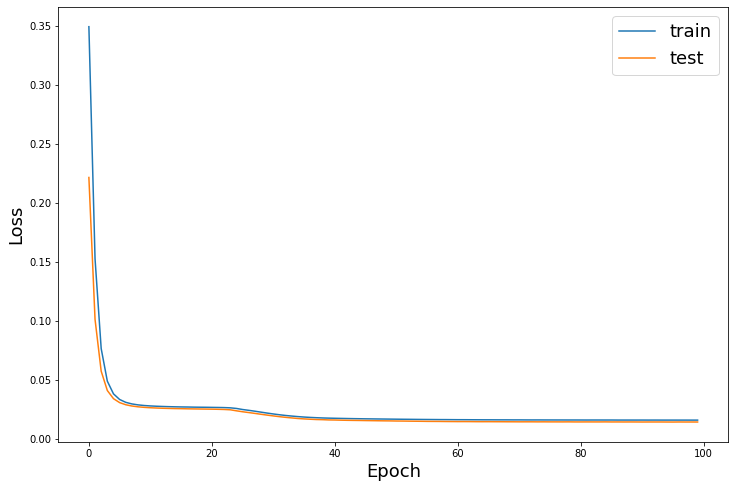

In [44]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('Loss',fontsize= 18)
plt.xlabel('Epoch',fontsize= 18)
plt.legend(['train', 'test'], loc='upper right', fontsize= 18);

# Predictions & Reconstruction Error

In [45]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()


,reconstruction_error,Label
count,910.000000,910.000000
mean,0.015461,0.026374
std,0.020940,0.160332
min,0.000467,0.000000
25%,0.004940,0.000000
50%,0.008795,0.000000
75%,0.018542,0.000000
max,0.152631,1.000000


Text(0.5, 1.0, 'Outlier Score')

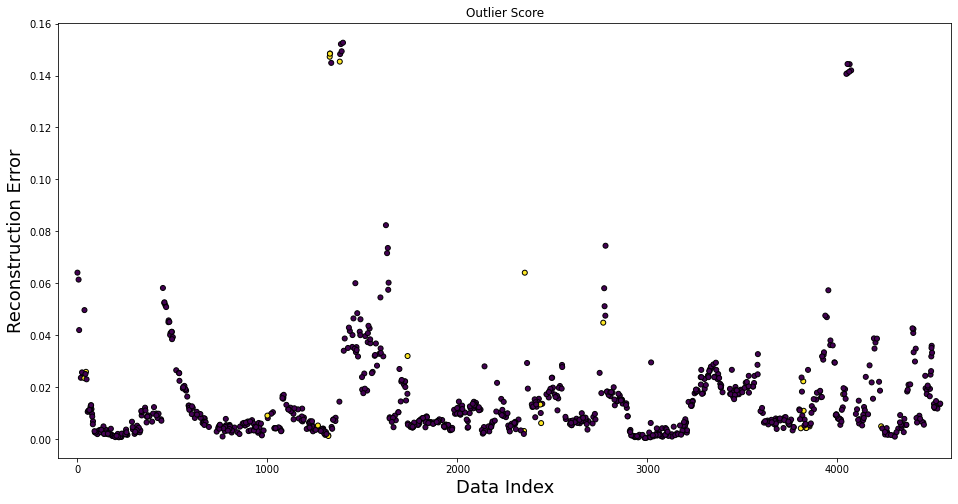

In [46]:
plt.figure(figsize=(16,8))
plt.scatter(df_error.index, df_error['reconstruction_error'], c=df_error['Label'], edgecolor='black', s=25)
plt.xlabel('Data Index', fontsize = 18)
plt.ylabel('Reconstruction Error', fontsize = 18)
plt.xlim((-100,4600))
plt.title("Outlier Score")


# Model Interpretability

- Major problem of neural network models is ...?


In [47]:
df_error.sort_values(ascending=False, by = 'reconstruction_error').head(10)

,reconstruction_error,Label
1398,0.152631,0
1387,0.152102,0
1391,0.149325,0
1330,0.148458,0
1329,0.148405,1
1383,0.148248,0
1328,0.147215,1
1381,0.145348,1
1336,0.144858,0
4054,0.144425,0


In [48]:
df_error.describe()

,reconstruction_error,Label
count,910.000000,910.000000
mean,0.015461,0.026374
std,0.020940,0.160332
min,0.000467,0.000000
25%,0.004940,0.000000
50%,0.008795,0.000000
75%,0.018542,0.000000
max,0.152631,1.000000


In [49]:
outliers = df_error.index[df_error.reconstruction_error > 0.1].tolist()

In [50]:
data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns=numerical_cols)

In [51]:
data_n.head()

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9
1192,0.623761,1.0,0.538462,0.643411,0.000678,0.991848,0.837209,0.937269,0.857143
2689,0.654662,1.0,0.615385,0.705426,0.000169,0.940217,0.869767,0.852399,0.653061
2351,0.604390,1.0,0.820513,0.643411,0.000508,0.839674,0.548837,0.778598,0.496599
3121,0.667710,1.0,0.743590,0.395349,0.000847,0.836957,0.897674,0.789668,0.789116
4513,0.662489,1.0,0.820513,0.310078,0.001863,0.880435,0.586047,0.826568,0.741497


In [52]:
def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = autoencoder.predict(initial_pt)
    
    return abs(np.array(initial_pt  - reconstrcuted_pt)[0])

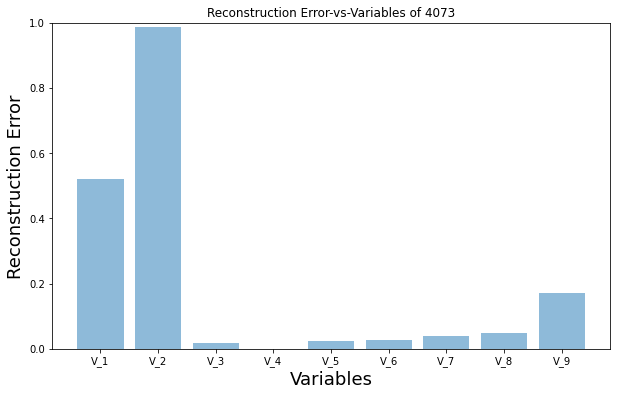

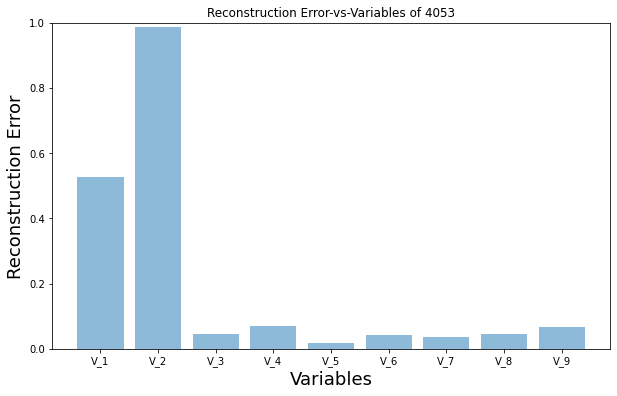

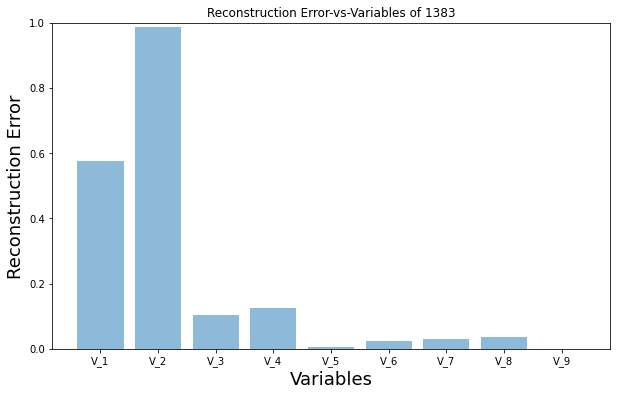

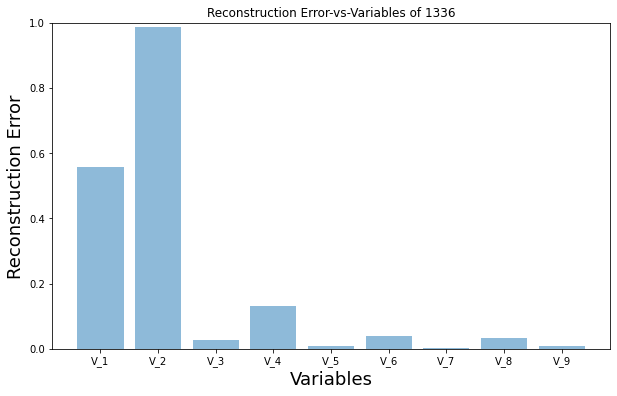

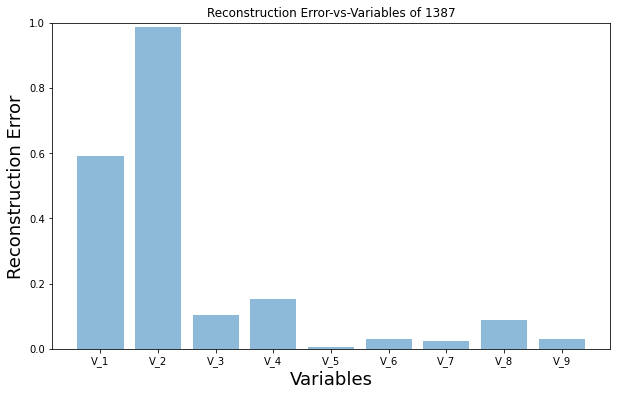

In [53]:
for i in outliers[:5]:
    
    plt.figure(figsize=(10,6))
    objects = tuple(numerical_cols) 
    y_pos   = np.arange(len(objects))
    x       = np.arange(len(objects))
    y       = compute_error_per_dim(i).tolist()
    plt.ylim([0, 1.0])
    plt.bar(x, y, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.xlabel('Variables',fontsize=18)
    plt.ylabel('Reconstruction Error', fontsize=18)
    plt.title('Reconstruction Error-vs-Variables of {}'.format(i))
 

# Conclusions

- **There is a patten for V_1 & V_2 in contributing mainly to the reconstruction error!**
- **AEs can be good choice to reduce dimensions in high dimensional data!**
- **AEs are good for outlier detections in complex data!**
